In [78]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import os
pd.set_option("display.max_colwidth", 500)
import requests
from bs4 import BeautifulSoup
from time import sleep
import random
import datetime
from PIL import Image
import re

import paswords

In [79]:
#画像のJs コード
def save_binary(url, filepath):
    js = """
    var getBinaryResourceText = function(url) {
        var req = new XMLHttpRequest();
        req.open('GET', url, false);
        req.overrideMimeType('text/plain; charset=x-user-defined');
        req.send(null);
        if (req.status != 200) return '';

        var filestream = req.responseText;
        var bytes = [];
        for (var i = 0; i < filestream.length; i++){
            bytes[i] = filestream.charCodeAt(i) & 0xff;
        }

        return bytes;
    }
    """
    js += "return getBinaryResourceText(\"{url}\");".format(url=url)

    data_bytes = driver.execute_script(js)
    with open(filepath, 'wb') as bin_out:
        bin_out.write(bytes(data_bytes))


capabilities = {
    'chromeOptions': {
        # 'androidPackage': 'com.android.chrome',
    }
}

In [80]:
#　集計の関数
def profile_data(user_html):
    user_data = pd.DataFrame(columns=['userid', 'name', 'age_area','regist_date','reported',
                                      'msg_switch','write_board','profile','height','weight',
                                      'work','drink','tobacco','marrege','types',
                                      'access_date']
                            )
    userid = user_html.find('div',{'class':'Box01 profile'})['userid']
    name= user_html.find('span',{'class':'font_lll font_red'}).text
    age_area = user_html.find('ul',{'class':'situation'}).find('li').text
    regist_date = user_html.find('ul',{'class':'statistics'}).find_all('li')[0].text
    reported = user_html.find('ul',{'class':'statistics'}).find_all('li')[1].text

    msg_switch = user_html.find('ul',{'class':'statistics'}).find_all('li')[2].text.split(':')[1]
    write_board = user_html.find('ul',{'class':'statistics'}).find_all('li')[3].text.split(':')[1]
    profile = user_html.find('div',{'class':'BoxGray'}).text
    height = user_html.find('div',{'class':'table03'}).find_all('dd')[0].text
    weight = user_html.find('div',{'class':'table03'}).find_all('dd')[1].text
    
    work = user_html.find('div',{'class':'table03'}).find_all('dd')[2].text
    drink = user_html.find('div',{'class':'table03'}).find_all('dd')[3].text
    tobacco = user_html.find('div',{'class':'table03'}).find_all('dd')[4].text
    marrege = user_html.find('div',{'class':'table03'}).find_all('dd')[5].text
    types = user_html.find('div',{'class':'table03'}).find_all('dd')[6].text
    
    access_date = datetime.date.today()
    
    series = pd.Series([userid, name, age_area,regist_date,reported,
                        msg_switch,write_board,profile,height,weight,
                        work,drink,tobacco,marrege,types,
                        access_date], 
                       index=user_data.columns
                      )
    
    user_data = user_data.append(series,ignore_index = True)
    return user_data

In [81]:
# メールを送るユーザーの判別式
def evaluation(user_d_data):
    evaluation_list = ['age','reported_cnt','msg_cnt','ngw_papa','ngw_otona','ngw_karada','ngw_sushi',
                       'ngw_yakiniku','ngw_support','ngw_yoyu','ngw_gentle','ngw_shogaku','ngw_yame',
                       'ngw_ryugaku','ngw_kosai','ngw_cup','ngw_shien','ngw_yume']
    user_evaluation = pd.Series(index=evaluation_list)
    user_evaluation['age'] = int(user_d_data['age_area'].str[:2])
    user_evaluation['reported_cnt'] = int(user_d_data['reported'].str.extract('(\d+)',expand=False))
    user_evaluation['msg_cnt'] = int(user_d_data['msg_switch'].str.extract('(\d+)',expand=False))    
    user_evaluation['ngw_papa'] = user_d_data['profile'].apply(lambda x: 'パパ' in x)
    user_evaluation['ngw_otona'] = user_d_data['profile'].apply(lambda x: '大人の関係' in x)
    user_evaluation['ngw_karada'] = user_d_data['profile'].apply(lambda x: 'の関係' in x)
    user_evaluation['ngw_sushi'] = user_d_data['profile'].apply(lambda x: '寿司' in x)
    user_evaluation['ngw_yakiniku'] = user_d_data['profile'].apply(lambda x: '焼肉' in x)
    user_evaluation['ngw_support'] = user_d_data['profile'].apply(lambda x: 'サポート' in x)
    user_evaluation['ngw_yoyu'] = user_d_data['profile'].apply(lambda x: '余裕' in x)
    user_evaluation['ngw_gentle'] = user_d_data['profile'].apply(lambda x: '紳士' in x)
    user_evaluation['ngw_shogaku'] = user_d_data['profile'].apply(lambda x: '奨学金' in x)
    user_evaluation['ngw_yame'] = user_d_data['profile'].apply(lambda x: '辞め' in x)
    user_evaluation['ngw_ryugaku'] = user_d_data['profile'].apply(lambda x: '留学' in x)
    user_evaluation['ngw_kosai'] = user_d_data['profile'].apply(lambda x: '交際' in x)
    user_evaluation['ngw_cup'] = user_d_data['profile'].apply(lambda x: 'カップ' in x)
    user_evaluation['ngw_shien'] = user_d_data['profile'].apply(lambda x: '支' in x)
    user_evaluation['ngw_yume'] = user_d_data['profile'].apply(lambda x: '夢' in x)

    
    if user_evaluation['age'] <= 30 and user_evaluation['reported_cnt'] <= 4 and user_evaluation['msg_cnt']<= 80\
    and user_evaluation['ngw_papa'] == False and user_evaluation['ngw_otona'] == False and user_evaluation['ngw_karada'] == False\
    and user_evaluation['ngw_sushi'] == False and user_evaluation['ngw_yakiniku'] == False and user_evaluation['ngw_support'] == False\
    and user_evaluation['ngw_yoyu'] == False and user_evaluation['ngw_gentle'] == False and user_evaluation['ngw_shogaku'] == False\
    and user_evaluation['ngw_yame'] == False and user_evaluation['ngw_ryugaku'] == False and user_evaluation['ngw_kosai'] == False\
    and user_evaluation['ngw_cup'] == False and user_evaluation['ngw_shien'] == False and user_evaluation['ngw_yume'] == False:
        return 1
    else:
        return 0

In [82]:
##今回はGoogleChromeを使用
driver = webdriver.Chrome("C:\webdriver\chromedriver.exe")
id = paswords.ID
password = paswords.PASSWORD

url = "https://sugardaddy.jp/login"
driver.get(url)
sleep(4)

In [83]:
#ログイン
driver.find_element_by_name("email").send_keys(id)
driver.find_element_by_name("pass").send_keys(password)
sleep(2)
driver.find_element_by_class_name('btn_black').send_keys(Keys.ENTER)


In [84]:
# create dataframe
user_columns = ['userid', 'name', 'age_area','regist_date','reported','msg_switch',
                'write_board','profile','height','weight','work','drink','tobacco',
                'marrege','types','access_date']

user_detail = pd.DataFrame(columns=user_columns)
user_good_detail = pd.DataFrame(columns=user_columns)


In [85]:
###　繰り返し場所

In [86]:
user_list = []

In [87]:
first_url = 'https://sugardaddy.jp/search'
driver.get(first_url)

In [88]:
for i in range(1,2):
    #　集計条件
    if i == 1:
        start_url = first_url
    else:
        start_url = first_url + '?my_pref=東京都&page=' + str(i)

    driver.get(start_url)
    sleep(1.5)
    serch = BeautifulSoup(driver.page_source,"html.parser")
    list= serch.find_all('div',{'class':'BoxPhotoProfile BoxGray clearfix'})
    for j in list:
        url = "https://sugardaddy.jp/profile?id=" + j['userid']
        user_list.append(url)

u_list = set(user_list)

In [89]:
len(u_list)

20

In [90]:
start_url = first_url

In [91]:
first_msg = 'はじめまして、こんばんわ。よかったらメッセージからお願いします。'

In [92]:
%%time
for i in u_list:
    driver.get(i)
    user_html = BeautifulSoup(driver.page_source,"lxml")
    try:
        user_on_data = profile_data(user_html)
        
        user_detail = user_detail.append(user_on_data)
        userid = user_on_data['userid'][0]
        photos = user_html.find_all('img',{'class':'popup'})
        n = 0
        for j in photos:
            try:
                img_url = ('https://sugardaddy.jp' + j['src'])
                file_name = '../img/' + userid + '_image_' + str(n) + '.jpeg'
                n += 1
                save_binary(img_url, file_name)
                if Image.open(file_name).size[0] == 300:
                    os.remove(file_name)
                sleep(0.5 + 1.5*random.random())        
            except:
                None
        # メッセージチェック
        file_name_1 = '../img/' + userid + '_image_' + str(0) + '.jpeg'
        print("")
        print(evaluation(user_on_data),' ',file_name_1,' ' ,end="")
        print(Image.open(file_name_1).size[0],end="")
        if Image.open(file_name_1).size[0] == 400 and evaluation(user_on_data) == 1:
            user_good_detail = user_good_detail.append(user_on_data)
            mssage_url = 'https://sugardaddy.jp/message?id=' + userid
            driver.get(mssage_url)
            sleep(3 + 2*random.random())
            mssage_html = BeautifulSoup(driver.page_source,"lxml")
            msg_check = mssage_html.find_all('div',{'class':'right_balloon'})
            if not msg_check:
                driver.find_element_by_id("msg_comment").send_keys(first_msg)
                driver.find_element_by_id('add').send_keys(Keys.ENTER)
                sleep(1 + 1*random.random())
                driver.get('https://sugardaddy.jp/message')
                print('send_mail',)
                sleep(1 + 1*random.random())
    except:
        None
    sleep(2 + 1*random.random())
    driver.get(start_url)
    sleep(1 + 1*random.random())


1   ../img/20581191926539_image_0.jpeg  400
1   ../img/20581191926103_image_0.jpeg  400
0   ../img/20581191905798_image_0.jpeg  400
1   ../img/20581191926776_image_0.jpeg  400
1   ../img/20581191926821_image_0.jpeg  
0   ../img/20581191908025_image_0.jpeg  400
0   ../img/20581191871258_image_0.jpeg  400
1   ../img/20581191921856_image_0.jpeg  400
0   ../img/20581191889786_image_0.jpeg  400
1   ../img/20581191909605_image_0.jpeg  400
0   ../img/20581191926643_image_0.jpeg  400
0   ../img/20581191851051_image_0.jpeg  400
0   ../img/20581191925982_image_0.jpeg  
1   ../img/20581191919777_image_0.jpeg  
1   ../img/20581191898615_image_0.jpeg  
0   ../img/20581191926813_image_0.jpeg  400
0   ../img/20581191924630_image_0.jpeg  400
1   ../img/20581191926763_image_0.jpeg  400
0   ../img/20581191918250_image_0.jpeg  400
0   ../img/20581191753571_image_0.jpeg  400Wall time: 4min 21s


In [73]:
save_date = '../user_detail/' + datetime.datetime.now().strftime("%Y%m%d_%H%M") + '.csv'
user_detail.to_csv(save_date)

In [23]:
#### ここまで通常処理

In [266]:
len(user_good_detail)

10

In [279]:
user_good_detail

,userid,name,age_area,regist_date,reported,msg_switch,write_board,profile,height,weight,work,drink,tobacco,marrege,types,access_date
0,20581191923924,。mi_na,23歳／東京都,登録日:2019年03月07日,被通報:0回,9人,0回,\nいい出会いがあれば嬉しいです！\n人見知り気味なので理解してくださる方だと助かりますっ！\n,150～154cm,普通,その他,時々飲む,吸わない,独身,まずは食事から,2019-03-13
0,20581191895802,hikaru22,22歳／東京都,登録日:2018年12月23日,被通報:1回,60人,1回,\nいいご縁があればとおもい\n登録しました！\nよければ仲良くしてください(^^)\n\n好きなことは\n映画鑑賞\nファッション\nドライブ\nおいぬ\nです。よろしくお願いします！\n,160～164cm,普通,会社員,時々飲む,吸わない,独身,まずは食事から,2019-03-13
0,20581191860266,世菜,19歳／東京都,登録日:2018年09月17日,被通報:0回,3人,0回,\nはじめまして、こんにちは☀️\n語学を勉強している学生です。\n\n未成年なのでお酒は飲めません🙇🏻\n\n最近、親知らずが生えてきたみたいで、左側で噛むのが辛いです。\n\n\n,150～154cm,普通,学生,飲まない,吸わない,独身,まずは食事から,2019-03-13
0,20581191926334,やまなかなのか,23歳／東京都,登録日:2019年03月12日,被通報:0回,0人,0回,\n趣味🌼映画鑑賞、美味しいお店探し\n性格🌼マイペース\n好きな食べ物🌼魚\nなどなどです(*´ー｀*)ゞ\nよろしくおねがいします☻\n\n,165～169cm,普通,その他,飲む,吸う,独身,まずは食事から,2019-03-13
0,20581191922708,yoko.1292,26歳／東京都,登録日:2019年03月04日,被通報:0回,22人,0回,\nはじめまして！\n都内で働く会社員です。\n\n食べ歩きやカフェめぐりが大好きなので、\n一緒に楽しめる方がいれば嬉しいです😊\n高級レストランとかよりも\nけむけむの焼き鳥とかに一緒に行ってくださる方の方が\n合うと思います。\n\n,155～159cm,やや細め,会社員,時々飲む,吸わない,独身,まずは食事から,2019-03-13


In [184]:
user_d_data = user_on_data

evaluation_list = ['age','reported_cnt','msg_cnt','ngw_papa','ngw_otona','ngw_karada','ngw_sushi',
                   'ngw_yakiniku','ngw_support','ngw_yoyu','ngw_gentle','ngw_shogaku','ngw_yame',
                   'ngw_ryugaku','ngw_kosai','ngw_cup','ngw_shien','ngw_yume']
user_evaluation = pd.Series(index=evaluation_list)
user_evaluation['age'] = int(user_d_data['age_area'].str[:2])
user_evaluation['reported_cnt'] = int(user_d_data['reported'].str.extract('(\d+)',expand=False))
user_evaluation['msg_cnt'] = int(user_d_data['msg_switch'].str.extract('(\d+)',expand=False))

In [185]:
user_evaluation['ngw_papa'] = user_d_data['profile'].apply(lambda x: 'パパ' in x)
user_evaluation['ngw_otona'] = user_d_data['profile'].apply(lambda x: '大人の関係' in x)
user_evaluation['ngw_karada'] = user_d_data['profile'].apply(lambda x: '体の関係' in x)
user_evaluation['ngw_sushi'] = user_d_data['profile'].apply(lambda x: '寿司' in x)
user_evaluation['ngw_yakiniku'] = user_d_data['profile'].apply(lambda x: '焼肉' in x)
user_evaluation['ngw_support'] = user_d_data['profile'].apply(lambda x: 'サポート' in x)
user_evaluation['ngw_yoyu'] = user_d_data['profile'].apply(lambda x: '余裕' in x)
user_evaluation['ngw_gentle'] = user_d_data['profile'].apply(lambda x: '紳士' in x)
user_evaluation['ngw_shogaku'] = user_d_data['profile'].apply(lambda x: '奨学金' in x)
user_evaluation['ngw_yame'] = user_d_data['profile'].apply(lambda x: '辞め' in x)
user_evaluation['ngw_ryugaku'] = user_d_data['profile'].apply(lambda x: '留学' in x)
user_evaluation['ngw_kosai'] = user_d_data['profile'].apply(lambda x: '交際' in x)
user_evaluation['ngw_cup'] = user_d_data['profile'].apply(lambda x: 'カップ' in x)
user_evaluation['ngw_shien'] = user_d_data['profile'].apply(lambda x: '支援' in x)
user_evaluation['ngw_yume'] = user_d_data['profile'].apply(lambda x: '夢' in x)

In [186]:
user_evaluation

age             24.0
reported_cnt     0.0
msg_cnt          7.0
ngw_papa         0.0
ngw_otona        0.0
ngw_karada       0.0
ngw_sushi        0.0
ngw_yakiniku     0.0
ngw_support      0.0
ngw_yoyu         0.0
ngw_gentle       0.0
ngw_shogaku      0.0
ngw_yame         0.0
ngw_ryugaku      0.0
ngw_kosai        0.0
ngw_cup          0.0
ngw_shien        0.0
ngw_yume         0.0
dtype: float64

In [178]:
if user_evaluation['age'] <= 30 and user_evaluation['reported_cnt'] <= 4 and user_evaluation['msg_cnt']<= 80\
and user_evaluation['ngw_papa'] == False and user_evaluation['ngw_otona'] == False and user_evaluation['ngw_karada'] == False\
and user_evaluation['ngw_sushi'] == False and user_evaluation['ngw_yakiniku'] == False and user_evaluation['ngw_support'] == False\
and user_evaluation['ngw_yoyu'] == False and user_evaluation['ngw_gentle'] == False and user_evaluation['ngw_shogaku'] == False\
and user_evaluation['ngw_yame'] == False and user_evaluation['ngw_ryugaku'] == False and user_evaluation['ngw_kosai'] == False\
and user_evaluation['ngw_cup'] == False and user_evaluation['ngw_shien'] == False and user_evaluation['ngw_yume'] == False:
    print(True)
else:
    print(False)

True


In [182]:
user_d_data['profile'].apply(lambda x: '夢' in x)

0    False
Name: profile, dtype: bool

In [183]:
 user_d_data['profile'].apply(lambda x: '支援' in x)

0    False
Name: profile, dtype: bool

In [171]:
evaluation_list = ['age','reported_cnt','ngw_papa','msg_cnt','ngw_otona','ngw_karada','ngw_sushi',
                   'ngw_yakiniku','ngw_support','ngw_yoyu','ngw_gentl','ngw_shogaku','ngw_yame',
                   'ngw_ryugaku','ngw_kosai','ngw_cup','ngw_shien']
user_evaluation = pd.DataFrame(columns=evaluation_list)

In [172]:
user_evaluation

,age,reported_cnt,ngw_papa,msg_cnt,ngw_otona,ngw_karada,ngw_sushi,ngw_yakiniku,ngw_support,ngw_yoyu,ngw_gentl,ngw_shogaku,ngw_yame,ngw_ryugaku,ngw_kosai,ngw_cup,ngw_shien


In [20]:
im = Image.open('../img/20581191912154_image_1.jpeg')

In [46]:
hoge['img'][0] =　img_list[0]

SyntaxError: invalid character in identifier (<ipython-input-46-09f747c47760>, line 1)

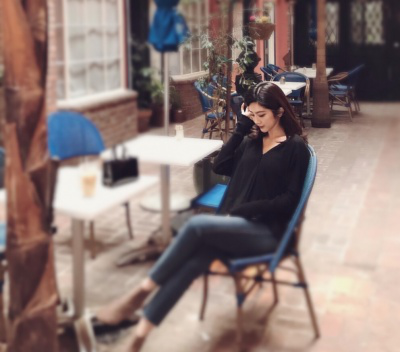

In [40]:
hoge['img']

In [ ]:
w48